<b>Deep Learning LAB-9

<b>Name: </b> Nikhil V

<b>Roll No: </b> CH.EN.U4AIE22038

<b>Lab - 9 : </b> Text Generation using LSTM



# Importing the required modules

In [4]:
pip install keras-preprocessing


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Modules for data handling and visualization
import pandas as pd
import numpy as np

# Modules for word cloud visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Modules for string handling
import string

# Modules for LSTM model building, compiling and training 
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Modules for data reproducibility
import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)

# Loading and Preprocessing the dataset

For the preprocessing of the data we follow the following steps:
- Atfirst we drop all headlines that are empty.
- Removal of all punctuation characters.
- Creating word vectors based on the word index.
- Add padding to the word vectors to transform them into a uniform size.

In [6]:
class Dataset:
   def __init__(self, data_dir : str):
       self.dir = data_dir
       self.headlines = []
       self.df = None
       self.text = None
       self.tokenizer = Tokenizer()
       self.input = []
       self.max_length = 0
       self.words = None
       self.total_words = 0
       self.x_train = None
       self.y_train = None


   def load_dataset(self):
       self.df = pd.read_csv(self.dir)
       self.headlines = list(self.df.headline.values)
       self.headlines = [h for h in self.headlines if h != "Unknown"]

   def __clean_text(self,text : str):
       self.ch = []
       for i in text:
           if i not in string.punctuation:
              self.ch.append(i)
       self.text = "".join(self.ch).lower()
       preprocessed_data = self.text.encode("utf8").decode("ascii",'ignore')
       return preprocessed_data

   def __create_word_vector(self, preprocessed_data : list[str]):
       self.tokenizer.fit_on_texts(preprocessed_data)
       self.total_words = len(self.tokenizer.word_index) + 1

       for line in preprocessed_data:
            tokens = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(tokens)):
                n_gram_sequence = tokens[:i+1]
                self.input.append(n_gram_sequence)

   def __pad_vectors(self):
       self.max_length = max(map(len, self.input))
       self.input = np.array(pad_sequences(self.input, 
                                  maxlen=self.max_length, 
                                  padding='pre'))
    
       self.x_train, self.y_train = self.input[:,:-1],self.input[:,-1]
       self.y_train = ku.to_categorical(self.y_train, 
                                 num_classes=self.total_words)

   def preprocess_data(self):
       self.headlines = list(map(self.__clean_text, 
                                 self.headlines))
       self.__create_word_vector(self.headlines)
       self.__pad_vectors()

   def summarise(self):
        plt.figure(figsize=(25,25))
        text = " ".join(self.headlines)
        stopwords = set(STOPWORDS)
        
        wordcloud = WordCloud(background_color='white',
                              stopwords=stopwords,
                              max_words=300,
                              max_font_size=35,
                              scale=3,
                              random_state=1)
   
        wordcloud=wordcloud.generate(text)

        plt.imshow(wordcloud)

## Loading the dataset

In [10]:
d = Dataset(r"C:\Users\Sudeesh Kumar V\OneDrive\Desktop\sem-5\Deep Learning\LAB Work\LAB-9\ArticlesApril2017.csv")


In [11]:
d.load_dataset()

## Glimpse into the different headlines

In [12]:
d.headlines

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College',
 'Initial Description',
 'Rough Estimates',
 'El Pasatiempo Nacional',
 'Cooling Off on a Hot Day at Yankee Stadium',
 'Trump’s Staff Mixed Politics and Paydays',
 'A Virtuoso Rebuilding Act Requires Everyone in Tune',

## Preprocessing the data

In [13]:
d.preprocess_data()

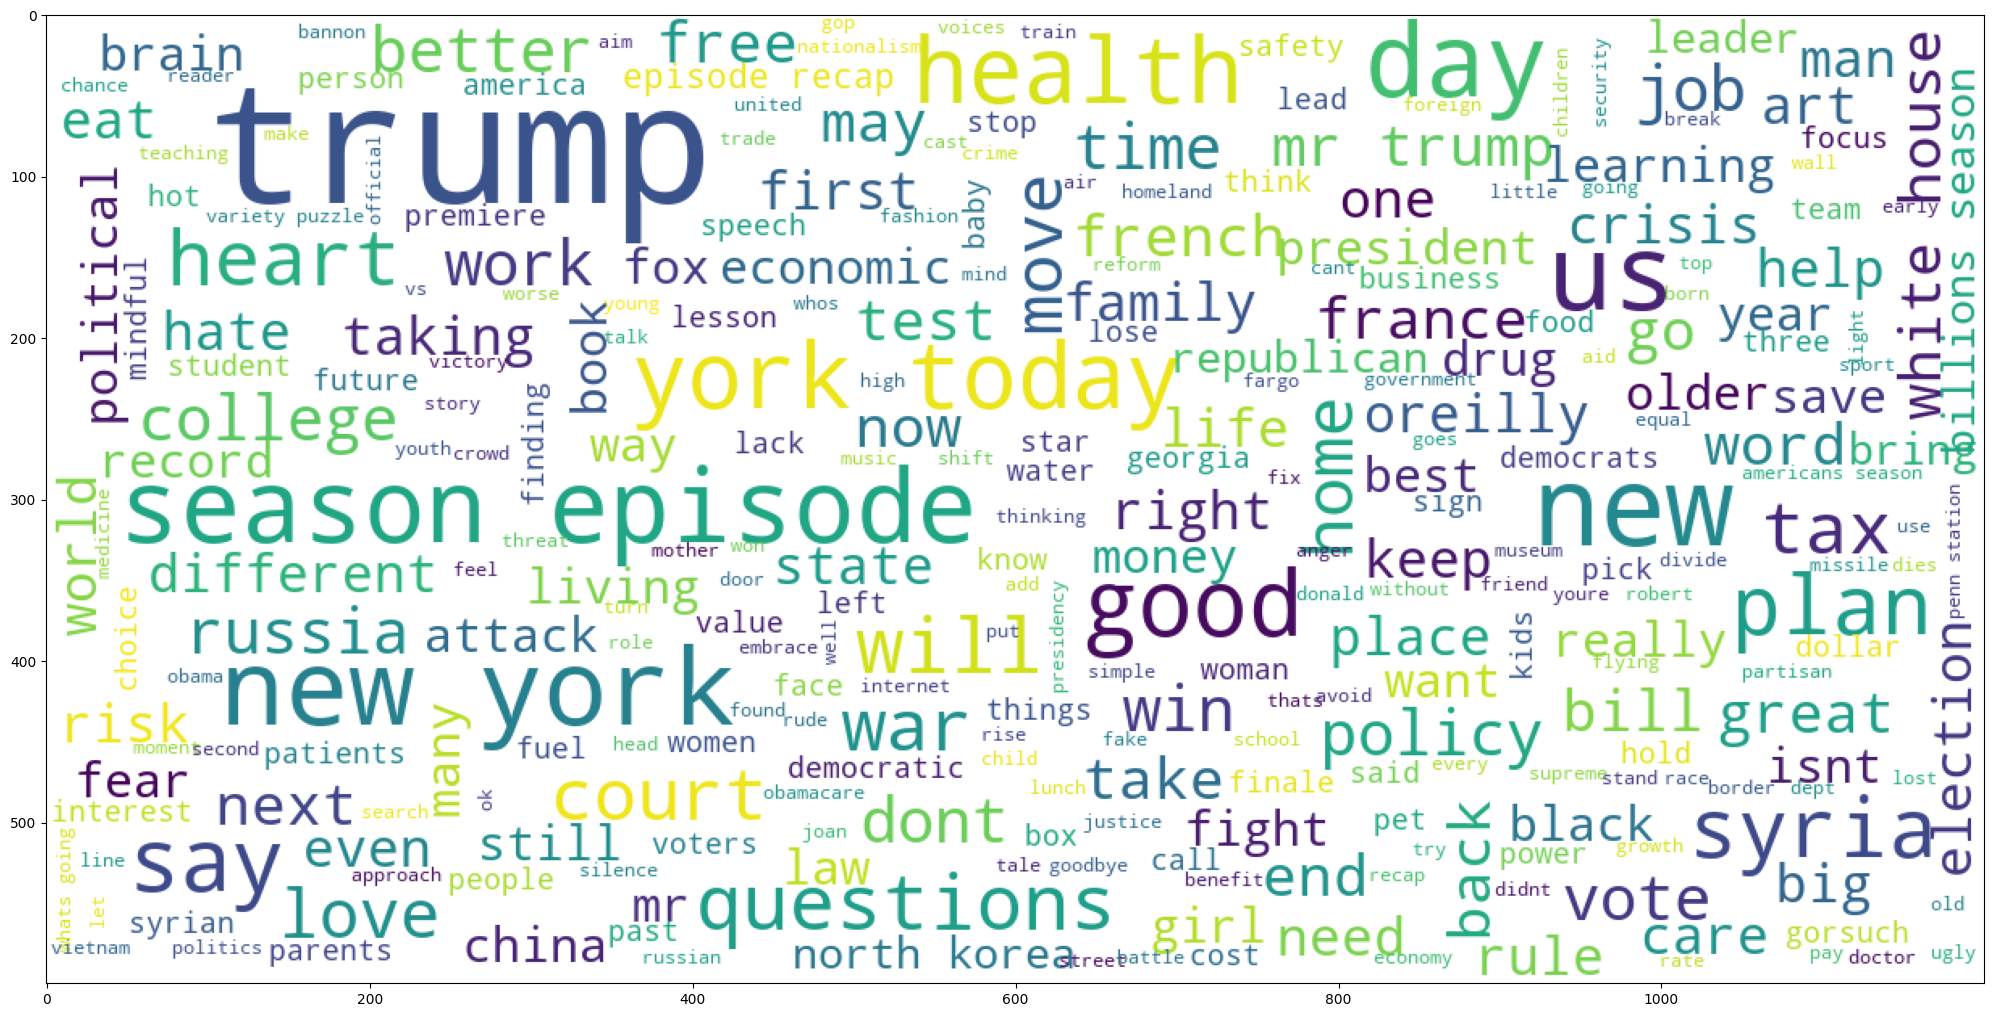

In [14]:
d.summarise()

# Design model for Text Generator

In [15]:
class TextGenerator:
    def __init__(self, max_len : int, n_words : int, x_train, y_train, tokenizer):
        self.input_dim = max_len - 1
        self.model = None
        self.nwords = n_words 
        self.tokenizer = tokenizer  
        self.x_train = x_train
        self.y_train = y_train

    def design_model(self):
        self.model = Sequential()
        self.model.add(Embedding(self.nwords, 
                                 10, 
                                 input_length=self.input_dim))
        self.model.add(LSTM(100))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(self.nwords, 
                             activation='softmax'))
        self.model.summary()

    def compile_model(self):
        self.model.compile(loss='categorical_crossentropy', 
                           optimizer='adam')

    def fit_model(self):
        self.model.fit(self.x_train, self.y_train, epochs=100)

    def generate_text(self, text, num_words):
        for _ in range(num_words):
            token_list = self.tokenizer.texts_to_sequences([text])[0]
            token_list = pad_sequences([token_list], maxlen=self.input_dim, padding='pre')
            predicted = self.model.predict(token_list, verbose=0)
            predicted = np.argmax(predicted, axis=1)
            
            output_word = ""
            for word,index in self.tokenizer.word_index.items():
                #print(word, index)
                if index == predicted:
                    output_word = word
                    break
            text += " "+output_word
        return text.title()

## Designing the model

In [16]:
tg = TextGenerator(d.max_length, d.total_words, d.x_train, d.y_train, d.tokenizer)

In [17]:
tg.design_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 10)            24220     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2422)              244622    
                                                                 
Total params: 313242 (1.19 MB)
Trainable params: 313242 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling the model

In [18]:
tg.compile_model()

## Fitting the model

In [19]:
tg.fit_model()

Epoch 1/100

151/151 [==============================] - 2s 6ms/step - loss: 7.3753
Epoch 2/100
151/151 [==============================] - 1s 6ms/step - loss: 6.9108
Epoch 3/100
151/151 [==============================] - 1s 6ms/step - loss: 6.7943
Epoch 4/100
151/151 [==============================] - 1s 6ms/step - loss: 6.7157
Epoch 5/100
151/151 [==============================] - 1s 6ms/step - loss: 6.6389
Epoch 6/100
151/151 [==============================] - 1s 6ms/step - loss: 6.5504
Epoch 7/100
151/151 [==============================] - 1s 6ms/step - loss: 6.4443
Epoch 8/100
151/151 [==============================] - 1s 6ms/step - loss: 6.3406
Epoch 9/100
151/151 [==============================] - 1s 6ms/step - loss: 6.2385
Epoch 10/100
151/151 [==============================] - 1s 6ms/step - loss: 6.1288
Epoch 11/100
151/151 [==============================] - 1s 6ms/step - loss: 6.0226
Epoch 12/100
151/151 [==============================] - 1s 6ms/step - loss: 5.9190
Epoch 13/100

## Text Generation

In [20]:
words = ["flights", "fight", "trump", "tax",  "good", "new", "episode", "deep"]
all_text = ""
for i in words:
     generated_text = tg.generate_text(i, 20)
     all_text += " " + generated_text

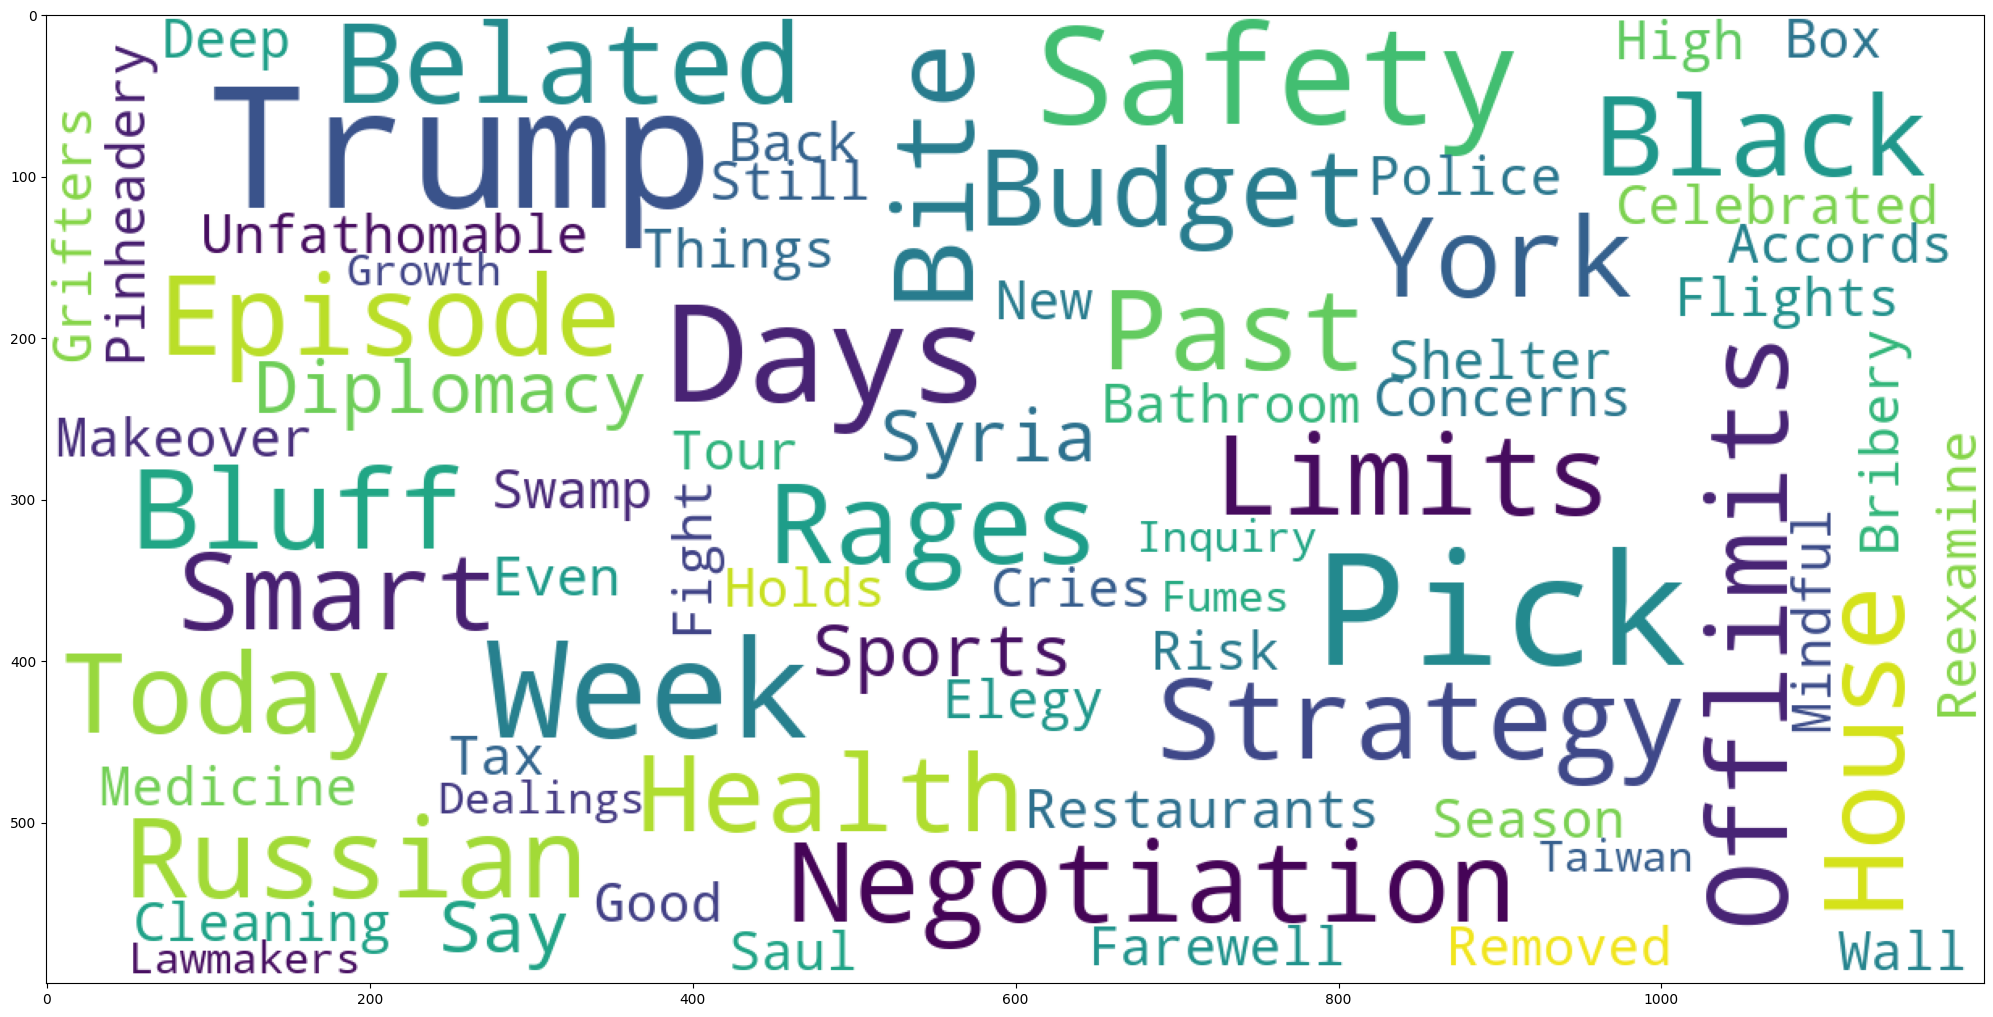

In [21]:
plt.figure(figsize=(25,25))
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white',
                        stopwords=stopwords,
                        max_words=300,
                        max_font_size=35,
                        scale=3,
                        random_state=1)

wordcloud=wordcloud.generate(all_text)

plt.imshow(wordcloud)

# Conclusions

- LSTM will learn the patterns in the articles by following which word can be followed by another word.
- LSTM generates text though it may not be grammatically correct.
- For a better text generation we need for more data and resources. Finally, the result of the model is depicted as a word cloud above.
- Hence, a text generator was created using LSTMs on the New York Times articles dataset.